In [178]:
import numpy as np
import cv2
import torchvision
import torch
import torch.nn as nn  
import json 
from sklearn.cluster import KMeans
from skimage.measure import label
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from src.tracker.utils import get_crops_from_boxes
from src.optical_flow.optical_flow import compute_optical_flow, compute_optical_flows_of_sequence, visualize_flow
import torchvision.transforms.functional as TF
from src.detector.object_detector import init_detector
from src.detector.visualize import colour_map_of_binary_masks

In [179]:
path = f"data/MOT16/train/MOT16-02-mini/img1/{1:06d}.jpg"
obj_detect = init_detector(**json.load(open("config/obj_detect/maskrcnn.json")))

flows = compute_optical_flows_of_sequence(path)
image = TF.to_tensor(Image.open(path).convert("RGB"))
obj_detect.eval();
with torch.no_grad():
    det = obj_detect([image])[0]

In [357]:

def binary_mask_from_flow(flow, magnitude_thresh=1):
    """
    transform optical flow into a binary mask, by setting True for every image point, where the magnitude is above a threshold
    """
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    flow_mask =  magnitude > magnitude_thresh
    return torch.from_numpy(flow_mask).unsqueeze(0)

def mask_cluster_filtering(mask, pixels_per_cluster=10, n_clusters=10, cluster_box_ratio_threshold=3, method="connected"):
    """
    remove noise from binary mask by only keeping points that belong to a cluster

    Arguments
    ---------
    mask: [1, H, W]

    Return
    ------
    mask: [1, H, W]
    """
    filtered_mask = np.zeros_like(mask, dtype=np.bool8)
    mask_coord = np.argwhere(mask.squeeze().numpy())
    if len(mask_coord) < pixels_per_cluster:
        return filtered_mask

    elif method == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters).fit(mask_coord)
        labels, counts = np.unique(kmeans.labels_, return_counts=True)
        keep = np.isin(kmeans.labels_, labels[counts > pixels_per_cluster])
        mask_coord = mask_coord[keep]
        filtered_mask[:, mask_coord[:, 0], mask_coord[:, 1]] = True
        return filtered_mask

    elif method == "connected":
        scalar_mask = torch.from_numpy((label(mask.squeeze().numpy()))).unsqueeze(0)
        keep_clusters = []
        for cluster in np.unique(scalar_mask)[1:]:
            cluster_mask = cluster == scalar_mask
            cluster_box = torchvision.ops.masks_to_boxes(cluster_mask)
            _, _, w, h = torchvision.ops.box_convert(cluster_box, "xyxy", "cxcywh").squeeze()
            if cluster_mask.sum() > pixels_per_cluster and h/w > cluster_box_ratio_threshold:
                keep_clusters.append(cluster)
        if not keep_clusters:
            return filtered_mask
        filtered_mask = torch.cat([(scalar_mask == cluster).float() for cluster in keep_clusters], dim=0).sum(0, keepdim=True).bool()
        return filtered_mask

def zoom_in_on_crops(crops, factor):
    """
    zoom in on center of image crops by given factor, without changing the shape
    """
    zoomed_crops = []
    for crop in crops:
        height = crop.shape[1]
        width = crop.shape[2]
        x_padding = int((factor-1)/2 * width)
        y_padding = int((factor-1)/2 * height)
        zoom = TF.resize(crop, size=(int(factor*height), int(factor*width)))
        zoom_crop = zoom[:, y_padding:y_padding+height, x_padding:x_padding+width]
        zoomed_crops.append(zoom_crop)
    return zoomed_crops

def get_undected_flow_crops(
    boxes, 
    masks, 
    flow, 
    apply_cluster_filtering=True, 
    zoom_factor=1.3, 
    magnitude_thresh=1, 
    pixels_per_cluster=100, 
    cluster_box_ratio_threshold=3
    ):
    """
    return list of cropped out binary masks with
        1: area that is not covered by mask, but is covered by optical flow
        0: area that is covered by mask


    Arguments
    ---------
    boxes: [N, 4] in xyxy format
    masks: [N, 1, H, W]
    flow: [H, W, 2]
    apply_cluster_filtering : if True, noise is removed from the optical flow masks

    Returns
    -------
    list of N * [1, H, W]
    """
    mask_crops = [
        get_crops_from_boxes(
            boxes=box.unsqueeze(0), image=mask
        )[0]
        for (box, mask) in zip(boxes, masks)
    ]
    mask_crops = zoom_in_on_crops(
        crops=mask_crops, 
        factor=zoom_factor
    )
    flow_mask = binary_mask_from_flow(
        flow=flow, 
        magnitude_thresh=magnitude_thresh
    )

    flow_crops = [
        get_crops_from_boxes(
            boxes=box.unsqueeze(0),
            image=flow_mask
        )[0] 
        for box in boxes
    ]

    undetected_flow_crops = [
        ~mask.bool() * flow 
        for (mask, flow) in zip(mask_crops, flow_crops)
    ]
    if apply_cluster_filtering:
        undetected_flow_crops = [
            mask_cluster_filtering(
                mask=crop, 
                pixels_per_cluster=pixels_per_cluster, 
                method="connected",
                cluster_box_ratio_threshold=cluster_box_ratio_threshold,
            ) 
            for crop in undetected_flow_crops
        ]

    return undetected_flow_crops


def get_region_proposals_on_crops(crops):
    areas = []
    for crop in crops:
        width = crop.shape[-1]
        center = int(width/2)
        right_area = crop[..., center:].sum()
        left_area = crop[..., :center].sum()
        areas.append({"left_area": left_area, "right_area": right_area})
    return areas 

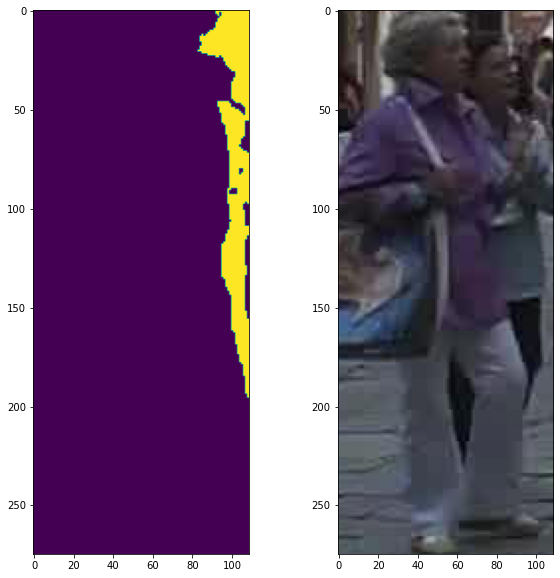

In [374]:
masks = det["masks"]
boxes = det["boxes"]

crops = get_undected_flow_crops(
    boxes=boxes, masks=masks, flow=flows[0], 
    apply_cluster_filtering=True, 
    cluster_box_ratio_threshold=3,
    zoom_factor=1.3, 
    magnitude_thresh=0.25, 
    pixels_per_cluster=500
)

obj_id = 4
fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(10, 10))
ax[0, 0].imshow(crops[obj_id].squeeze())

img_crops = get_crops_from_boxes(boxes=boxes, image=image)
ax[0, 1].imshow(img_crops[obj_id].permute(1, 2, 0))

# TODO : show how you can use this to track objects before they are large enough to be detected